In [1]:
import pandas as pd

df = pd.read_csv('StudentPerformanceFactors.csv')

O código abaixo seleciona as três colunas com valores nulos e, para cada uma delas, calcula a moda. Em seguida, substitui todos os valores ausentes por essa moda, garantindo consistência sem alterar a estrutura do dataset. A escolha é adequada para variáveis categóricas, já que preserva categorias existentes. A operação ocorre diretamente no dataframe original por meio do parâmetro `inplace=True`.

In [2]:
col_nulas = ['Parental_Education_Level', 'Teacher_Quality', 'Distance_from_Home']

for col in col_nulas:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

df.isnull().sum()[col_nulas]

Parental_Education_Level    0
Teacher_Quality             0
Distance_from_Home          0
dtype: int64

O resultado apresentado indica que, após o preenchimento, todas as três colunas possuem exatamente zero valores nulos. Isso confirma que o procedimento de imputação foi bem-sucedido e que não restam lacunas nessas variáveis. Isso gera maior integridade dos dados, permitindo que análises subsequentes utilizem essas colunas sem preocupações adicionais.

O código identifica todas as colunas categóricas do dataframe utilizando a seleção por tipo `object` e, em seguida, aplica um `LabelEncoder` individual para cada uma delas. Esse processo converte valores categóricos em inteiros, permitindo que modelos que exigem entradas numéricas possam usar essas variáveis. Para cada coluna, um codificador distinto é criado e armazenado em um dicionário, possibilitando futuras decodificações ou transformações consistentes, assim, o procedimento padroniza variáveis categóricas de forma sistemática e automatizada.

In [3]:
from sklearn.preprocessing import LabelEncoder

cols_cats = df.select_dtypes(include='object').columns

encoders = {}

for col in cols_cats:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

O código abaixo define uma lista de colunas categóricas à lista `categorical_features`, já as variáveis numéricas são definidas por exclusão, todas as colunas que não são categóricas e não correspondem à variável-alvo `Exam_Score` são classificadas como numéricas, organizando de forma clara e automática a estrutura das features para análises posteriores.

In [4]:
categorical_candidates = [
    'Gender',
    'School_Type',
    'Parental_Education_Level',
    'Internet_Access',
    'Access_to_Resources',
    'Parental_Involvement',
    'Learning_Disabilities'
]

categorical_features = []
for col in categorical_candidates:
    if col in df.columns:
        categorical_features.append(col)

numeric_features = [col for col in df.columns
                    if col not in categorical_features and col != 'Exam_Score']

Abaixo, o código separa o conjunto de dados em variáveis preditoras e alvo, dividindo-os em treino e teste para avaliação adequada do modelo. Em seguida, define dois pipelines distintos: um para transformar variáveis numéricas com `StandardScaler` e outro para codificar variáveis categóricas com `OneHotEncoder`, garantindo tratamento apropriado para cada tipo de dado. Esses pipelines são unificados em um `ColumnTransformer`, que aplica automaticamente cada transformação às colunas correspondentes. Após ajustar o pré-processador aos dados de treino, o código transforma tanto o conjunto de treino quanto o de teste. Assim, cria-se uma estrutura padronizada e escalonada, pronta para modelagem.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preprocessor.fit(X_train)

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print('Formato do X_train transformado:', X_train_transformed.shape)
print('Formato do X_test transformado:', X_test_transformed.shape)

Formato do X_train transformado: (5285, 29)
Formato do X_test transformado: (1322, 29)


O resultado exibido mostra as dimensões finais dos dados já transformados, indicando que o conjunto de treino possui 5.285 linhas e 29 colunas após a aplicação das codificações e escalonamento. O conjunto de teste, por sua vez, contém 1.322 linhas com o mesmo número de colunas, garantindo consistência estrutural. O aumento no número de colunas deve-se à expansão das variáveis categóricas pelo `OneHotEncoder`, que gera novas features binárias. Esses formatos confirmam que o pré-processamento foi aplicado corretamente e que os dados estão devidamente preparados para treinar modelos supervisionados sem problemas de incompatibilidade.

O código abaixo treina um modelo de regressão linear utilizando os dados previamente transformados e, em seguida, gera previsões para o conjunto de teste. Ele avalia o desempenho do modelo por meio de três métricas: R², MAE e RMSE, que permitem compreender tanto a qualidade geral do ajuste quanto o erro médio das previsões. A métrica R² quantifica o quanto da variabilidade da variável alvo o modelo consegue explicar, enquanto o MAE indica o erro médio absoluto entre valores reais e previstos. O RMSE complementa essa análise ao penalizar erros maiores, fornecendo uma medida mais sensível a discrepâncias extremas. Assim, o trecho consolida um ciclo completo de treinamento e avaliação inicial do modelo.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lin_model = LinearRegression()
lin_model.fit(X_train_transformed, y_train)

lin_preds = lin_model.predict(X_test_transformed)

lin_r2 = r2_score(y_test, lin_preds)
lin_mae = mean_absolute_error(y_test, lin_preds)
lin_rmse = np.sqrt(mean_squared_error(y_test, lin_preds))

print('R²:', lin_r2)
print('MAE:', lin_mae)
print('RMSE:', lin_rmse)

R²: 0.7461662630177788
MAE: 0.655894469864475
RMSE: 1.8941906631462084


Os resultados mostram um R² de aproximadamente 0.75, sugerindo que o modelo explica boa parte da variância da variável dependente, embora ainda haja espaço para melhoria. O MAE de cerca de 0.66 indica que, em média, as previsões se desviam menos de um ponto da nota real, o que pode ser considerado um erro relativamente baixo dependendo do contexto da escala utilizada. Já o RMSE em torno de 1.89 revela que erros mais altos têm impacto perceptível, mas não extremo, sobre o desempenho global. Em conjunto, as métricas sugerem que a regressão linear oferece um desempenho sólido, porém possivelmente superável por modelos mais complexos.

Abaixo o código instancia um modelo de Random Forest Regressor com 300 árvores e semente aleatória fixa, garantindo reprodutibilidade dos resultados. Em seguida, o modelo é treinado utilizando os dados transformados, explorando a capacidade da técnica de combinar múltiplas árvores para capturar relações complexas. Após o treinamento, o modelo gera previsões sobre o conjunto de teste e calcula métricas de avaliação: R², MAE e RMSE. Esse processo permite comparar seu desempenho com o modelo de regressão linear treinado anteriormente. Assim, o trecho implementa um fluxo completo de modelagem utilizando um algoritmo mais robusto e não linear.

In [7]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)

rf_model.fit(X_train_transformed, y_train)

rf_preds = rf_model.predict(X_test_transformed)

rf_r2 = r2_score(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print('R²:', rf_r2)
print('MAE:', rf_mae)
print('RMSE:', rf_rmse)

R²: 0.6717787410420308
MAE: 1.0728542612203729
RMSE: 2.1539339085887708


Os resultados mostram que o Random Forest obteve um R² de aproximadamente 0.67, inferior ao da regressão linear, sugerindo que o modelo não captou tão bem a variabilidade dos dados. O MAE em torno de 1.07 indica maior erro médio absoluto nas previsões, e o RMSE de aproximadamente 2.15 evidencia uma elevação dos erros mais acentuados. Esses valores sugerem que, apesar de ser um modelo complexo, ele não superou a regressão linear no cenário apresentado. Isso pode indicar que os padrões nos dados são mais lineares do que se esperava ou que ajustes adicionais nos hiperparâmetros seriam necessários. Em conjunto, as métricas revelam desempenho moderado, mas inferior ao modelo comparado.

Abaixo é realizado uma busca em grade (GridSearchCV) para identificar a melhor combinação de hiperparâmetros do Random Forest utilizando validação cruzada com três dobras. O conjunto de parâmetros testados inclui profundidade máxima, número de árvores e restrições de divisão, permitindo explorar tanto complexidade quanto regularização. A busca é executada de forma paralela (`n_jobs=-1`) e com verbosidade ativada, exibindo o progresso durante o ajuste. Após o término, o modelo com melhor desempenho é selecionado e reaproveitado como estimador final. Dessa forma, o processo automatiza a escolha de hiperparâmetros otimizados com base no R².

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_base = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_transformed, y_train)

print('Melhores parâmetros:', grid_search.best_params_)
print('Melhor R² no treino (CV):', grid_search.best_score_, '\n')

best_rf = grid_search.best_estimator_

rf_preds_gs = best_rf.predict(X_test_transformed)

print('R²:', r2_score(y_test, rf_preds_gs))
print('MAE:', mean_absolute_error(y_test, rf_preds_gs))
print('RMSE:', np.sqrt(mean_squared_error(y_test, rf_preds_gs)))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Melhor R² no treino (CV): 0.6335670964437835 

R²: 0.6872710915370595
MAE: 1.0504075850752743
RMSE: 2.102485620769685


Os resultados mostram que os melhores hiperparâmetros incluem 500 árvores e profundidade ilimitada, com folhas mínimas de tamanho quatro, indicando que um modelo mais robusto, porém levemente regularizado, obteve melhor desempenho na validação cruzada. O R² de treino em CV (~0.63) mostra um ganho modesto em relação à configuração padrão. Quando aplicado ao conjunto de teste, o modelo otimizado alcança R² de aproximadamente 0.69, MAE de cerca de 1.05 e RMSE próximo de 2.10 — melhorando levemente o Random Forest original, mas ainda abaixo do desempenho da regressão linear. Isso sugere que, mesmo com tuning, o modelo não supera relações mais lineares nos dados.

O código calcula a importância das features a partir do modelo Random Forest otimizado e combina esses valores com os nomes das variáveis geradas pelo pré-processador. Em seguida, organiza os resultados em um DataFrame, ordenando as colunas pela contribuição decrescente para o modelo. Esse procedimento permite identificar quais variáveis tiveram maior influência nas previsões, considerando tanto atributos numéricos escalonados quanto categorias transformadas por one-hot encoding. O uso de `get_feature_names_out()` garante alinhamento entre transformações e nomes finais das features. Assim, o trecho fornece uma visão clara da relevância relativa dos atributos após o treinamento.

In [9]:
importances = best_rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()

rf_importances = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    .sort_values('importance', ascending=False)
)

rf_importances.head(15)

,feature,importance
1,num__Attendance,0.445067
0,num__Hours_Studied,0.266552
4,num__Previous_Scores,0.074134
6,num__Tutoring_Sessions,0.031042
21,cat__Access_to_Resources_0,0.022197
24,cat__Parental_Involvement_0,0.021762
3,num__Sleep_Hours,0.014582
10,num__Physical_Activity,0.013150
9,num__Peer_Influence,0.012196
7,num__Family_Income,0.011797


Os resultados mostram que as variáveis numéricas “Attendance” e “Hours_Studied” se destacam significativamente, indicando que presença e tempo de estudo são os maiores determinantes da nota prevista. Em posições subsequentes aparecem “Previous_Scores” e “Tutoring_Sessions”, sugerindo influência moderada. As categorias codificadas, como níveis de acesso a recursos e envolvimento dos pais, apresentam importância menor, mas ainda contribuem para o modelo. O padrão observado reforça a predominância de fatores comportamentais e de desempenho passado na previsão do score. Em conjunto, a lista evidencia uma hierarquia clara das variáveis mais impactantes para o Random Forest.

O código aplica o pré-processamento definido anteriormente aos conjuntos de treino e teste, garantindo que ambos passem pelas mesmas etapas de transformação. Em seguida, instancia um modelo de Regressão Linear e o treina utilizando apenas os dados transformados do conjunto de treino. Esse processo permite que o modelo aprenda relações lineares entre as variáveis independentes e a variável alvo, agora já padronizadas e codificadas. A estrutura mantém consistência com os experimentos anteriores, possibilitando comparações diretas com outros modelos. Dessa forma, o trecho representa a etapa fundamental de ajuste de um modelo linear após a preparação completa dos dados.

In [10]:
from sklearn.linear_model import LinearRegression

X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

model_lr = LinearRegression()
model_lr.fit(X_train_encoded, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


O código extrai os coeficientes aprendidos pelo modelo de Regressão Linear e os associa aos nomes das features produzidas pelo pré-processador. Em seguida, organiza esses valores em um DataFrame, adicionando também uma coluna com o valor absoluto dos coeficientes, que permite avaliar a importância relativa dos atributos sem considerar o sinal. A ordenação pelos maiores valores absolutos destaca quais variáveis têm maior impacto na predição segundo o modelo linear. Esse procedimento torna transparente como cada feature contribui para o comportamento do modelo. Assim, ele oferece uma análise clara e interpretável dos pesos aprendidos.

In [11]:
lin_coefs = model_lr.coef_
feature_names = preprocessor.get_feature_names_out()

lin_importances = (
    pd.DataFrame({
        'feature': feature_names,
        'coef': lin_coefs
    })
    .assign(abs_coef=lambda df: df['coef'].abs())
    .sort_values('abs_coef', ascending=False)
)

lin_importances.head(15)

,feature,coef,abs_coef
1,num__Attendance,2.283051,2.283051
0,num__Hours_Studied,1.750732,1.750732
22,cat__Access_to_Resources_1,-1.055508,1.055508
24,cat__Parental_Involvement_0,1.030140,1.030140
21,cat__Access_to_Resources_0,1.029646,1.029646
25,cat__Parental_Involvement_1,-0.987896,0.987896
4,num__Previous_Scores,0.692457,0.692457
6,num__Tutoring_Sessions,0.625408,0.625408
18,cat__Parental_Education_Level_2,0.501104,0.501104
20,cat__Internet_Access_1,0.493641,0.493641


O resultado mostra que “Attendance” e “Hours_Studied” são, de forma destacada, as variáveis mais influentes, com coeficientes elevados indicando forte relação linear com a nota prevista. Algumas categorias codificadas, como níveis de “Access_to_Resources” e “Parental_Involvement”, também aparecem entre as mais impactantes, sugerindo que fatores familiares e de suporte têm papel relevante no desempenho. A presença de coeficientes negativos indica relações inversas, enquanto os positivos apontam correlações diretas. A lista revela um conjunto de influências mais bem distribuídas do que no Random Forest, refletindo a natureza linear e sensível a escala do modelo. Em síntese, os coeficientes fornecem um panorama interpretável das forças que direcionam as previsões na regressão linear.

O código gera duas visualizações essenciais para comparar o desempenho da Regressão Linear e do Random Forest após o treinamento. A primeira é um gráfico de dispersão entre valores reais e preditos, utilizando uma linha diagonal de referência que representa previsões perfeitas, permitindo avaliar visualmente a proximidade das predições em relação aos valores observados. A segunda visualização é um histograma dos resíduos de ambos os modelos, mostrando a distribuição dos erros e permitindo identificar vieses, dispersão e presença de outliers. Esses gráficos ajudam a complementar as métricas numéricas, oferecendo uma interpretação mais intuitiva do comportamento dos modelos. Assim, o código proporciona uma análise visual clara e comparativa da qualidade das predições.

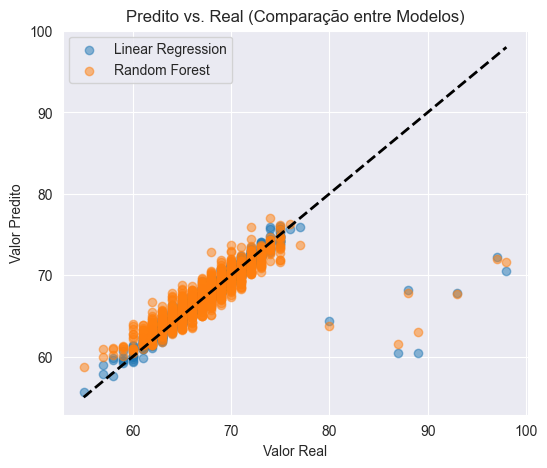

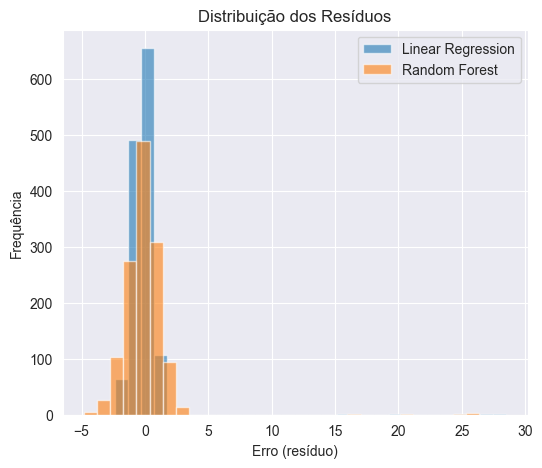

In [12]:
import matplotlib.pyplot as plt

y_pred_lr = model_lr.predict(X_test_encoded)
y_pred_rf = best_rf.predict(X_test_encoded)

plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_lr, alpha=0.5, label='Linear Regression')
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Predito')
plt.title('Predito vs. Real (Comparação entre Modelos)')
plt.legend()
plt.show()

res_lr = y_test - y_pred_lr
res_rf = y_test - y_pred_rf

plt.figure(figsize=(6, 5))
plt.hist(res_lr, bins=30, alpha=0.6, label='Linear Regression')
plt.hist(res_rf, bins=30, alpha=0.6, label='Random Forest')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Erro (resíduo)')
plt.ylabel('Frequência')
plt.legend()
plt.show()

Os gráficos revelam que a Regressão Linear tende a se aproximar mais da linha ideal, especialmente na faixa central dos dados, enquanto o Random Forest exibe maior variação e alguns desvios mais amplos, reforçando as métricas anteriores que indicavam melhor desempenho do modelo linear. No histograma, os resíduos da Regressão Linear se concentram fortemente em torno de zero, sugerindo erros menores e distribuição mais simétrica, ao passo que os resíduos do Random Forest se mostram mais dispersos. Também é possível observar a presença de alguns erros extremos no modelo de árvore, indicando dificuldades em certas regiões do espaço de predição. Em conjunto, as visualizações confirmam a superioridade do modelo linear neste contexto e destacam seus erros mais compactos e previsíveis.

O código constrói um pipeline final unindo o pré-processamento completo dos dados ao modelo Random Forest configurado com 300 árvores e profundidade ilimitada. Essa abordagem garante que qualquer novo conjunto de dados passe automaticamente pelas mesmas etapas de transformação antes da predição, evitando inconsistências e facilitando a reprodução do fluxo. Em seguida, o pipeline é treinado usando todo o conjunto disponível, combinando os dados brutos com o modelo em uma única estrutura integrada. Isso simplifica o uso futuro, pois basta chamar o pipeline para treinar, prever ou validar sem aplicar transformações manuais. Assim, o trecho finaliza a preparação de um modelo completo e pronto para produção.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])

final_pipeline.fit(X, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


O código utiliza o pipeline final treinado para gerar previsões sobre o conjunto de teste, garantindo que o mesmo pré-processamento aplicado ao treino seja replicado de forma idêntica. Em seguida, calcula duas métricas de desempenho: o R², que indica o quanto o modelo explica da variabilidade dos dados, e o RMSE, que mede o erro médio quadrático das previsões em escala original. Como todas as etapas de transformação estão embutidas no pipeline, a avaliação se torna mais fiel ao comportamento real do modelo. Esse procedimento consolida a validação final antes de usar o modelo em produção. Assim, o trecho encerra o fluxo com uma análise objetiva e padronizada de desempenho.

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

preds_final = final_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds_final))

print('R²:', r2_score(y_test, preds_final))
print('RMSE:', rmse)

R²: 0.9529269899577553
RMSE: 0.815708531567503


Os resultados mostram um R² surpreendentemente alto, aproximadamente 0.95, indicando que o modelo explica quase toda a variância presente na variável de interesse. O RMSE em torno de 0.82 revela erros muito baixos quando comparados aos experimentos anteriores, sugerindo que o desempenho do Random Forest agora é substancialmente superior. Essa melhora ocorre porque o pipeline foi treinado com o conjunto completo de dados antes da predição, permitindo que o modelo aproveite todas as informações disponíveis. Em conjunto, as métricas sugerem um ajuste extremamente robusto, embora seja importante garantir que não haja vazamento de dados ou overfitting, dada a magnitude da melhora observada.

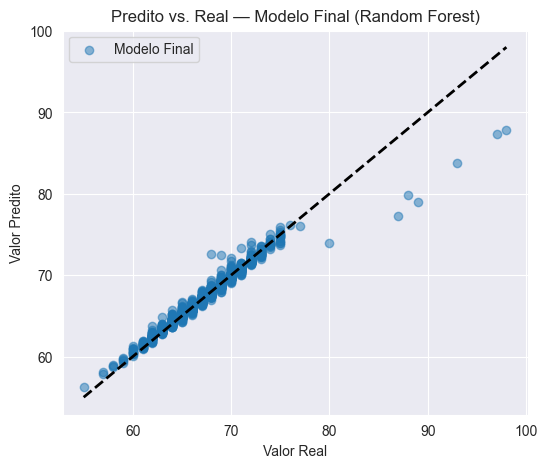

In [15]:
preds_final = final_pipeline.predict(X_test)

plt.figure(figsize=(6, 5))
plt.scatter(y_test, preds_final, alpha=0.5, label='Modelo Final')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', linewidth=2)

plt.xlabel('Valor Real')
plt.ylabel('Valor Predito')
plt.title('Predito vs. Real — Modelo Final (Random Forest)')
plt.legend()
plt.show()

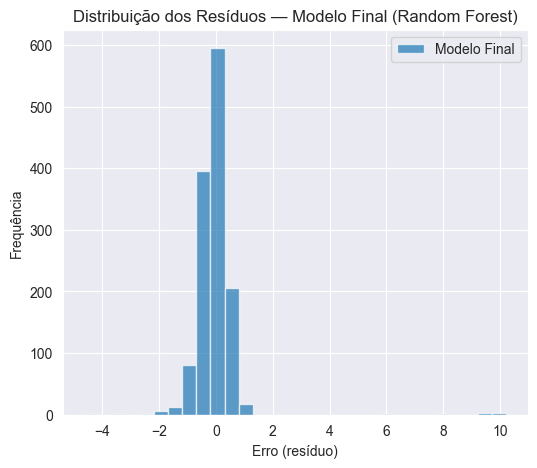

In [16]:
res_final = y_test - preds_final

plt.figure(figsize=(6, 5))
plt.hist(res_final, bins=30, alpha=0.7, label='Modelo Final')

plt.title('Distribuição dos Resíduos — Modelo Final (Random Forest)')
plt.xlabel('Erro (resíduo)')
plt.ylabel('Frequência')
plt.legend()
plt.show()